<a href="https://colab.research.google.com/github/Hackathorn/WILS-NEURIPS22/blob/master/notebooks/WILS-NEURIPS22-DataPrep-v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection of Localized Manifords

...Using NEURIPS22 Paper Abstracts. Derived from the Cohere Dashboard at https://dashboard.cohere.ai/playground/embed. A sample of 33 NEURIPS22 accepted papers (title + abstract) were extracted.

## Configure

In [12]:
%pip install -Uqqq cohere chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 966.7/966.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 5.8 MB/s 

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cohere
import chromadb as db

## Load and embed data

In [14]:
# upload repo locally
!rm -rf /content/WILS-NEURIPS22
!git clone https://github.com/Hackathorn/WILS-NEURIPS22.git

Cloning into 'WILS-NEURIPS22'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 63 (delta 24), reused 44 (delta 13), pack-reused 0
Unpacking objects: 100% (63/63), 529.52 KiB | 6.62 MiB/s, done.


In [15]:
# create list of abstracts to embed
with open("./WILS-NEURIPS22/doc/NEURIPS22-abstract-sample-UTF8.txt",   # for Colab
# with open("../doc/NEURIPS22-abstract-sample-UTF8.txt",  # for VScode
          encoding='utf-8', errors='ignore') as f:
    abstracts = f.readlines()

# ...plus their paper titles
titles = [a.split('.')[0].strip() for a in abstracts]

In [16]:
titles[:10]


['On Kernel-Target Alignment',
 'On the Convergence of Prior-Guided Zeroth-Order Optimization Algorithms',
 'Communication Complexity of Distributed Convex Learning and Optimization',
 'Straggler Mitigation in Distributed Optimization Through Data Encoding',
 'Finite Sample Convergence Rates of Zero-Order Stochastic Optimization Methods',
 'Efficient Pure Exploration in Adaptive Round model',
 'On Top-k Selection in Multi-Armed Bandits and Hidden Bipartite Graphs',
 'MaxGap Bandit: Adaptive Algorithms for Approximate Ranking',
 'A Smoothed Analysis of the Greedy Algorithm for the Linear Contextual Bandit Problem',
 'Identifying Outlier Arms in Multi-Armed Bandit']

In [17]:
# generate embeddings for abstracts
co = cohere.Client('9UQ2FJ61TaGMhZKBoiY7JeGa23qlEyPqmpNjER97') # This is your trial API key
response = co.embed(
  model='embed-english-v2.0',
  texts=abstracts,
)
# convert to np.array
embeddings = np.array(response.embeddings)

# show stats on embeddings
print(embeddings.shape)
print(embeddings.min())
print(embeddings.max())
print(embeddings.mean())
print(embeddings.std())


(33, 4096)
-9.9375
10.8828125
-0.0009693962722598167
1.2779840980922614


## Store embeddings into Chroma

In [19]:
# Create collection and add all the embeddings
client = db.Client()
collection = client.create_collection(name="NEURIPS22")
collection.add(
    documents=titles,
    ids=[f'id{i+1}' for i in range(len(titles))],
    embeddings=response.embeddings,
)

In [28]:
# get a few embeddings
collection.get(
    ids=['id1', 'id4', 'id23'],
)

{'ids': ['id1', 'id4', 'id23'],
 'embeddings': None,
 'documents': ['On Kernel-Target Alignment',
  'Straggler Mitigation in Distributed Optimization Through Data Encoding',
  'Active Information Retrieval'],
 'metadatas': [None, None, None]}

## Find the cluster

Trying various methods (with help from ChatGPT)

Elbow Method: The elbow method helps identify the number of clusters by plotting the within-cluster sum of squares (WCSS) against the number of clusters. The idea is to look for a point on the plot where adding more clusters does not significantly decrease the WCSS. This point resembles an elbow, hence the name. You can use the KMeans inertia_ attribute to calculate the WCSS.

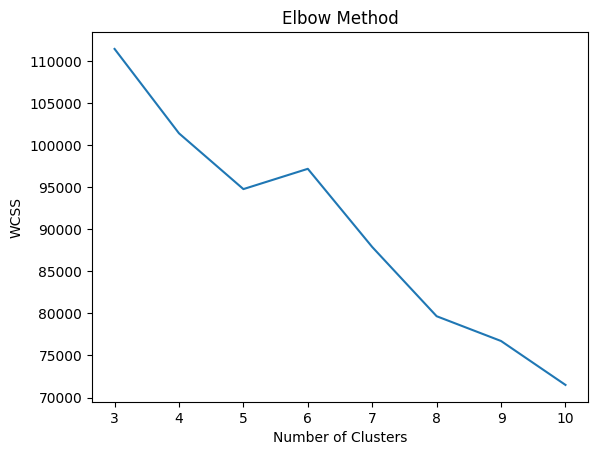

In [11]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assuming you have a list of 33 objects with their corresponding 4096-dimensional vectors
# objects = [...]  # Replace [...] with your actual object list
vectors = embeddings

# Define the range of clusters to try
min_clusters = 3
max_clusters = 10

# Calculate the within-cluster sum of squares (WCSS) for different cluster numbers
wcss = []
for num_clusters in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=num_clusters, n_init='auto')
    kmeans.fit(vectors)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values against the number of clusters
plt.plot(range(min_clusters, max_clusters + 1), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()


Silhouette Score: The silhouette score measures the quality of a clustering solution based on both the cohesion within clusters and the separation between clusters. Higher silhouette scores indicate better-defined clusters. You can use the silhouette_score function from the sklearn.metrics module to compute the silhouette score.

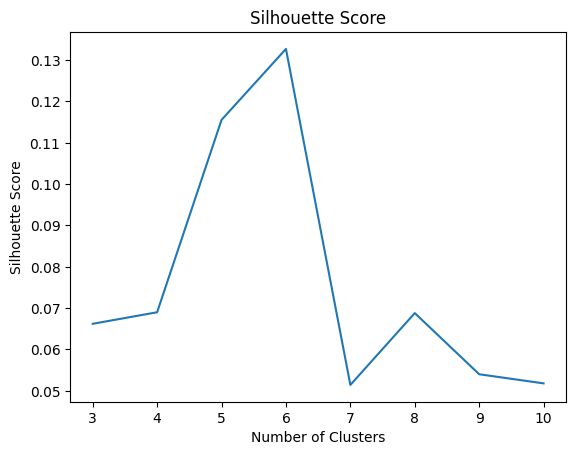

In [10]:
from sklearn.metrics import silhouette_score

# Assuming you have a list of 33 objects with their corresponding 4096-dimensional vectors
# objects = [...]  # Replace [...] with your actual object list  NOT USED
vectors = embeddings

# Define the range of clusters to try
min_clusters = 3
max_clusters = 10

# Calculate the silhouette score for different cluster numbers
silhouette_scores = []
for num_clusters in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=num_clusters, n_init='auto')
    kmeans.fit(vectors)
    labels = kmeans.labels_
    score = silhouette_score(vectors, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores against the number of clusters
plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()


To find which object is assigned to which cluster using the K-means algorithm, you can access the labels_ attribute of the KMeans object. The labels_ attribute contains the cluster labels assigned to each object in the same order as the input data.

Here's an updated version of the code that includes printing the assigned cluster labels for each object:

In [ ]:
from sklearn.cluster import KMeans

# Assuming you have a list of 33 objects with their corresponding 4096-dimensional vectors
objects = [...]  # Replace [...] with your actual object list
vectors = [...]  # Replace [...] with your actual 4096-dimensional vectors

# Create a KMeans object with the desired number of clusters
num_clusters = 3  # Adjust this value based on your needs
kmeans = KMeans(n_clusters=num_clusters)

# Fit the KMeans model to your data
kmeans.fit(vectors)

# Get the predicted cluster labels for each object
labels = kmeans.labels_

# Print the cluster labels for each object
for i in range(len(objects)):
    print(f"Object: {objects[i]}, Cluster: {labels[i]}")


In [ ]:
!pip install -qq umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -qq umap-learn[plot]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import umap

In [ ]:
# prompt: use UMAP to find clusters in embeddings without reducing dimensionality, given mapping of abstracts to cluster_ids

# find cluster IDs for each abstract
clusterer = umap.UMAP(n_neighbors=100, min_dist=0.1, )
cluster_ids = clusterer.fit
# cluster_ids = clusterer.fit_predict(embeddings)

# plot UMAP embedding of abstracts, colored by cluster ID
plt.figure(figsize=(12, 12))
sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], hue=cluster_ids, palette="tab10")
plt.title("UMAP Embedding of Abstracts")
plt.show()

In [ ]:
cluster_ids


<bound method UMAP.fit of UMAP(n_neighbors=100)>

In [ ]:
use UMAP to find clusters in embeddings without reducing dimensionality, given mapping of abstracts to cluster_ids


SyntaxError: ignored

In [ ]:
# prompt: Using UMAP, find the clusters in embeddings

import umap

reducer = umap.UMAP()
embedding_umap = reducer.fit_transform(embeddings, )


In [ ]:
# prompt: plot the clusters in embedding_map

plt.scatter(*embedding_umap.T, c=response.cluster_ids, cmap='tab10')
plt.title('UMAP visualization of document clusters')
plt.show()

AttributeError: ignored